# Imports and paths

In [243]:
import os
import sys

# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

import polars as pl
import pandas as pd
import numpy as np

In [244]:
from config import TRAIN_PARQUET_PATH, TEST_PARQUET_PATH
from src.data.loaders import PolarsLoader
from src.utils import filter_polars, timer_and_memory

## Train and test processing

In [245]:
loader = PolarsLoader(sampling=True, file_type='parquet')
train = loader.load_data(path=TRAIN_PARQUET_PATH)
test = loader.load_data(path=TEST_PARQUET_PATH)

In [246]:
print("*"*50)
print("TRAIN DATA:")
print("*"*50)
print("Unique session IDs")
print(train['session_id'].n_unique())

print("\nNumber of interacted products")
print(train['partnumber'].n_unique())

print("\nDate range:")
print(train['date'].min())
print(train['date'].max()) #----> Extraer entonces solo: NUMERO DIA, NUMERO DIA DE LA SEMANA, NOMBRE DIA DE LA SEMANA, NUMERO HORA, MAÑANA/TARDE/NOCHE

print("\n","*"*50)
print("TEST DATA:")
print("*"*50)
print("Unique session IDs")
print(test['session_id'].n_unique())

print("\nNumber of interacted products")
print(test['partnumber'].n_unique())

print("\nDate range:")
print(test['date'].min())
print(test['date'].max())

**************************************************
TRAIN DATA:
**************************************************
Unique session IDs
95364

Number of interacted products
26380

Date range:
2024-06-01
2024-06-15

 **************************************************
TEST DATA:
**************************************************
Unique session IDs
7349

Number of interacted products
9253

Date range:
2024-06-15
2024-06-16


I saved all products in train/test data to drop the "not present" in products data

In [247]:
# # Save products in train/test to reduce product dataset
# train_prods = train.select('partnumber').unique()
# train_prods = list(train_prods.to_series())

# test_prods = test.select('partnumber').unique()
# test_prods = list(test_prods.to_series())

# print("Total number of products in train + test datasets: ", len(set(train_prods + test_prods)))

# all_prods = list(set(train_prods + test_prods))

# # Save to JSON
# with open(ALL_PRODS_TRAINTEST_PATH, 'w') as f:
#     json.dump(all_prods, f)

### Downsample train

In [248]:
train['add_to_cart'].value_counts(normalize=True)

add_to_cart,proportion
u8,f64
1,0.059276
0,0.940724


### NA imputation

In [249]:
def impute_train_test(df):
    
    # Add tag for known user first
    df = df.with_columns([
        pl.when(pl.col("user_id").is_null()).then(pl.lit(-1)).otherwise(pl.lit(1)).alias("known_user"),
    ])

    return df.with_columns([pl.col("user_id").fill_null(-1).cast(pl.Int32),
                        pl.col("pagetype").fill_null(pl.col("pagetype").mode()),
                        ])

train = impute_train_test(train)
test = impute_train_test(test)

### Create page, device and country features for both train and test (concatenate)

In [250]:
def create_concatenated_features(train: pl.DataFrame, 
                               test: pl.DataFrame) -> tuple[pl.DataFrame, 
                                                            pl.DataFrame]:
    """
    Create cart ratio features by concatenating train and test data, computing ratios,
    then returning the separated dataframes with new features.
    
    Args:
        train (pl.DataFrame): Training dataframe containing 'add_to_cart' column
        test (pl.DataFrame): Test dataframe without 'add_to_cart' column
    
    Returns:
        tuple[pl.DataFrame, pl.DataFrame]: Tuple containing (train, test) dataframes with new features
    """
    # Create dummy test dataframe with placeholder add_to_cart column
    dummy_test = (test.clone()
                 .with_columns([pl.lit(None).alias('add_to_cart')])
                 .select(sorted(train.columns, reverse=True))
                 .with_columns([pl.lit(0).alias('flag')])
    )
    
    # Prepare train dataframe with flag
    dummy_train = (train
                  .select(sorted(train.columns, reverse=True))
                  .with_columns([pl.lit(1).alias('flag')])
    )
    
    # Concatenate train and test
    traintest_concat = pl.concat([dummy_train, dummy_test])
    # Calculate page type cart addition ratio
    page_cart_ratio = (traintest_concat.group_by("pagetype")
                      .agg(pl.col("add_to_cart").mean().alias("page_cart_ratio").cast(pl.Float32))
                      .fill_null(pl.lit(-1))
                      .with_columns(pl.col("pagetype").cast(pl.UInt8))
    )
    traintest_concat = traintest_concat.join(page_cart_ratio, on="pagetype", how="left")
    # Calculate device type cart addition ratio
    device_cart_ratio = (traintest_concat.group_by("device_type")
        .agg(pl.col("add_to_cart").mean().alias("device_cart_ratio").cast(pl.Float32))
    )
    traintest_concat = traintest_concat.join(device_cart_ratio, on="device_type", how="left")
    # Calculate country cart addition ratio
    country_cart_ratio = (traintest_concat.group_by("country")
        .agg(pl.col("add_to_cart").mean().alias("country_cart_ratio").cast(pl.Float32))
    )
    traintest_concat = traintest_concat.join(country_cart_ratio, on="country", how="left")
    
    # Calculate cumulative user features
    traintest_concat = traintest_concat.with_columns([
            pl.col("add_to_cart").cum_sum().over("user_id").alias("user_previous_cart_additions"),
            pl.col("user_id").cum_count().over("user_id").alias("user_previous_interactions")
        ])
    
    # Split back into train and test based on flag
    train_processed = traintest_concat.filter(pl.col("flag") == 1).drop("flag")
    test_processed = traintest_concat.filter(pl.col("flag") == 0).drop(["flag", "add_to_cart"])
    
    return train_processed, test_processed


train, test = create_concatenated_features(train, test)

In [109]:
print(set(train['pagetype'].unique()))
print(set(train['pagetype'].unique()).intersection(set(test['pagetype'].unique())))
print(set(test['pagetype'].unique()).difference(set(train['pagetype'].unique())))

{1, 3, 5, 6, 7, 8, 9, 10, 12, 14, 16, 17, 19, 20, 21, 23, 24, 25, 29}
{1, 6, 7, 8, 16, 17, 19, 24, 25}
{26}


In [110]:
print(set(train['partnumber'].unique()))
print(set(train['partnumber'].unique()).intersection(set(test['partnumber'].unique())))
print(set(test['partnumber'].unique()).difference(set(train['partnumber'].unique())))

{3, 4, 5, 8, 11, 12, 14, 18, 20, 22, 23, 27, 28, 29, 30, 31, 33, 35, 37, 39, 40, 41, 43, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 59, 60, 61, 63, 65, 66, 68, 72, 73, 74, 75, 76, 77, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 91, 92, 93, 96, 97, 101, 102, 103, 104, 105, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 126, 127, 130, 132, 133, 134, 136, 138, 141, 145, 146, 153, 154, 155, 157, 158, 159, 161, 163, 164, 166, 167, 168, 169, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 184, 185, 186, 187, 188, 189, 190, 195, 196, 198, 203, 208, 209, 211, 215, 216, 217, 223, 225, 226, 231, 235, 236, 240, 247, 248, 249, 250, 252, 254, 255, 256, 261, 262, 264, 265, 266, 267, 268, 269, 272, 275, 276, 277, 278, 281, 282, 283, 284, 285, 287, 288, 290, 293, 294, 296, 297, 298, 300, 303, 304, 305, 309, 311, 312, 313, 314, 315, 316, 317, 318, 319, 321, 322, 325, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 346, 3

In [8]:
# # Is each session from a single user? SI
# train.drop_nulls()\
#     .group_by('session_id')\
#         .agg(pl.col('user_id').n_unique())\
#             .sort('user_id', descending=True)

In [9]:
# Some session with several interactions
train.drop_nulls()\
    .group_by('session_id')\
        .agg(pl.col('user_id').count())\
            .sort('user_id', descending=True)\
                .filter(pl.col('user_id') >= 30)

session_id,user_id
u32,u32
3745893,6480
205622,2022
2247260,1619
2656537,1132
3058982,1115
…,…
2473080,30
4233868,30
2932758,30


In [ ]:
# 2 FEATURES IMPORTANTES A CREAR
# 1. Cuanto duro cada interaccion
# 2. Si es la primera interaccion con el producto o que numero es

@timer_and_memory
def feature_engineering_no_candidate_dependent(df: pl.DataFrame) -> pl.DataFrame:

    # Cleaning and sorting
    df_ = (df.drop("date")
           .sort("timestamp_local")
    )

    df_ = df_.with_columns([
        # Calculate the difference in timestamps within each session
        (pl.col("timestamp_local")
         .diff()
         .over("session_id").cast(pl.Float32) / 1_000_000)
         .round(1).alias("seconds_since_last_interaction"),
        # Total session duration in seconds
        ((pl.col("timestamp_local").max() - pl.col("timestamp_local").min())
         .over("session_id").cast(pl.Float32) / 1_000_000)
         .round(1).alias("total_session_time"),
    ]).fill_null(strategy="zero")

    df_ = df_.with_columns([
                pl.col("seconds_since_last_interaction").shift(-1).over("session_id").alias("interaction_length"),
    ]).fill_null(strategy="zero")

    # Date features
    df_ = df_.with_columns([
        # Extracting day number
        pl.col("timestamp_local").dt.day().alias("day_number"),
        
        # Extracting weekday number
        pl.col("timestamp_local").dt.weekday().alias("weekday_number"),
        
        # Extracting weekday name
        # pl.col("timestamp_local").dt.strftime("%A").alias("weekday_name").cast(pl.Categorical),
        
        # Extracting hour
        pl.col("timestamp_local").dt.hour().alias("hour")
    ])

    df_ = df_.with_columns([
                        pl.when((pl.col("hour") >= 6) & (pl.col("hour") < 12)).then(pl.lit(0))
                        .when((pl.col("hour") >= 12) & (pl.col("hour") < 18)).then(pl.lit(1))
                        .when((pl.col("hour") >= 18) & (pl.col("hour") < 24)).then(pl.lit(2))
                        .otherwise(pl.lit(3))
                        .cast(pl.UInt8)
                        .alias("day_frame")
                    ])

    return df_

train_eng = feature_engineering_no_candidate_dependent(train)
test_eng = feature_engineering_no_candidate_dependent(test)
test_eng

Function 'feature_engineering_no_candidate_dependent' executed in 0.53 seconds and Peak memory usage: 0.009 MB.
Function 'feature_engineering_no_candidate_dependent' executed in 0.05 seconds and Peak memory usage: 0.004 MB.


session_id,timestamp_local,user_id,country,partnumber,device_type,pagetype,seconds_since_last_interaction,total_session_time,interaction_length,day_number,weekday_number,hour,day_frame
u32,datetime[μs],i32,u8,u16,u8,u8,f32,f32,f32,i8,i8,i8,u8
2792280,2024-06-15 00:00:35.309,-1,34,34990,1,24,0.0,0.0,0.0,15,6,0,3
2650545,2024-06-15 00:00:39.307,-1,34,39690,1,24,0.0,38.599998,10.6,15,6,0,3
2650545,2024-06-15 00:00:49.953,-1,34,14862,1,24,10.6,38.599998,7.1,15,6,0,3
2650545,2024-06-15 00:00:57.030,-1,34,37325,1,24,7.1,38.599998,6.8,15,6,0,3
2650545,2024-06-15 00:01:03.848,-1,34,33088,1,24,6.8,38.599998,14.1,15,6,0,3
…,…,…,…,…,…,…,…,…,…,…,…,…,…
1097839,2024-06-16 23:54:17.231,452923,25,15804,1,24,28.9,150.100006,33.599998,16,7,23,2
131295,2024-06-16 23:54:19.351,-1,34,8588,3,24,29.0,1020.799988,0.0,16,7,23,2
1097839,2024-06-16 23:54:50.854,452923,25,21003,1,24,33.599998,150.100006,49.5,16,7,23,2


In [11]:
#1 session example
# train_eng.filter(pl.col('session_id') == 3033819).tail()

## Selecting candidates
This is the plan...

- Global Popular Products:
    - Select 50–100 most popular products globally.
    - Use these as candidates for all sessions.

- Country-Specific Popular Products:
    - For each session, identify the user's country.
    - Select the 50–100 most popular products for that country.

- Similar Products:
    For every session, regardless of user history:
    - Select ~20 products most similar to the product(s) in the interaction.
    - User History Products:

For users with history in the Train dataset:
Include all products they interacted with but did not add to the cart.

## Adding candidates to test
- I have to add them at the end of session (max timestamp) for the feature to "count interaction"
- I have to drop duplicate addition because that "count" would increase

### 1. Take Top popular products from train
I create a dataframe with top 500 to later select how many to feed to test

In [12]:
cart_counts = (train_eng
 .group_by('partnumber')
 .agg(pl.col('add_to_cart').count())
 .sort('add_to_cart', descending=True)
 .limit(500)
)

In [13]:
cart_counts

partnumber,add_to_cart
u16,u32
1181,3234
41749,3221
32700,1313
33777,1177
11031,903
…,…
43112,279
1552,279
36192,278


Total products:  500


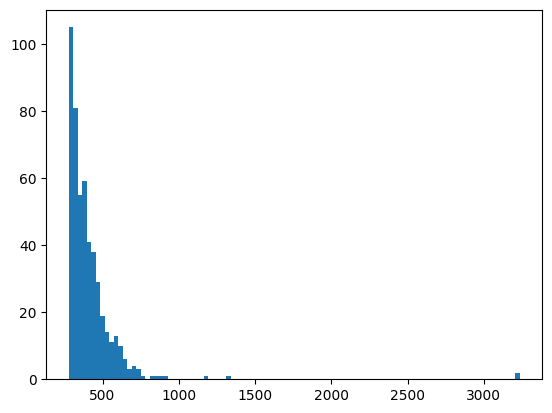

In [14]:
import matplotlib.pyplot as plt
cart_additions = 200
selected_plot = cart_counts.filter(pl.col('add_to_cart')> cart_additions)
print("Total products: ", cart_counts['partnumber'].n_unique())
plt.hist(cart_counts.filter(pl.col('add_to_cart')> cart_additions)['add_to_cart'], bins=100);

### 2. Add to test

In [15]:
# Some session with several interactions
test_eng.drop_nulls()\
    .group_by('session_id')\
        .agg(pl.col('user_id').count())\
            .sort('user_id', descending=True)\
                .filter(pl.col('user_id') >= 5)

session_id,user_id
u32,u32
3728971,10
178554,10
411601,10
2576029,10
1085087,10
…,…
4646749,5
2666940,5
1197405,5


In [16]:
TOPN_GLOBAL = 10
top_global_prods = cart_counts['partnumber'].head(TOPN_GLOBAL).to_list()

In [17]:
def add_candidates_to_test(test_df: pl.DataFrame, candidate_products: list) -> pl.DataFrame:
    """Adds candidate products as new rows for each session in test data"""
    test_session_ids = test_df["session_id"].unique()

    # Create a dataframe with all the candidate products for each session
    candidates = [
        {"session_id": sid, "partnumber": pn}
        for sid in test_session_ids 
        for pn in candidate_products
    ]
    candidates_df = pl.DataFrame(candidates).with_columns([
        pl.col("session_id").cast(pl.UInt32),
        pl.col("partnumber").cast(pl.UInt16)
    ])
    
    # Add the candidate products to the test data
    test_extended = pl.concat([test_df, candidates_df], how="diagonal").unique()

    # Fill missing values with generated
    # test_extended = test_extended.group_by("session_id").map_groups(
    #             lambda group: group.sort("timestamp_local", descending=True)
    #             .fill_null(strategy="backward"))

    #Fill missing values with generated: Faster version
    backfilled_cols = ['timestamp_local',
                        'user_id',
                        'country',
                        'device_type',
                        'pagetype',
                        'total_session_time',
                        'day_number',
                        'weekday_number',
                        # 'weekday_name',
                        'hour',
                        'day_frame']
    
    statsfilled_cols = ['seconds_since_last_interaction',
                        'interaction_length']
    
    test_extended = (test_extended
                    .sort(["session_id", "timestamp_local"], descending=[False, True])
                    .with_columns([
                        pl.col(col).fill_null(strategy='backward').over("session_id") 
                        for col in backfilled_cols
                    ])
                    .with_columns([
                        pl.col(col).fill_null(strategy='mean').over("session_id") 
                        for col in statsfilled_cols
                    ])
                )

    return test_extended

In [18]:
test_extended = add_candidates_to_test(test_eng, top_global_prods)

### 3. Create extra features depending on candidates

In [19]:
def feature_engineering_candidate_dependent(df: pl.DataFrame) -> pl.DataFrame:
    
    df = df.with_columns([
        # Assign a cumulative count for each partnumber within a session
        pl.col("partnumber").cum_count().over(["session_id", "partnumber"]).alias("product_interaction_count")
    ]).fill_null(strategy="zero")

    return df

In [20]:
train_eng = feature_engineering_candidate_dependent(train_eng)
test_extended = feature_engineering_candidate_dependent(test_extended)

# Adding products and user features

In [22]:
train_eng.head()

session_id,timestamp_local,add_to_cart,user_id,country,partnumber,device_type,pagetype,seconds_since_last_interaction,total_session_time,interaction_length,day_number,weekday_number,hour,day_frame,product_interaction_count
u32,datetime[μs],u8,i32,u8,u16,u8,u8,f32,f32,f32,i8,i8,i8,u8,u32
3430915,2024-06-01 02:00:00.399,0,-1,57,11490,1,24,0.0,889.900024,40.5,1,6,2,3,1
3859571,2024-06-01 02:00:00.829,0,-1,34,16688,1,24,0.0,1890.599976,48.700001,1,6,2,3,1
2706260,2024-06-01 02:00:01.985,0,-1,34,6807,1,24,0.0,129.300003,9.2,1,6,2,3,1
3686634,2024-06-01 02:00:03.828,0,-1,34,14566,1,24,0.0,1686.800049,11.2,1,6,2,3,1
4175670,2024-06-01 02:00:09.282,0,-1,57,22950,1,24,0.0,253.399994,1.4,1,6,2,3,1


In [ ]:
from config import USERS_ENGINEERED_PATH
prods = loader.load_data(path=TRAIN_PARQUET_PATH)